<a href="https://colab.research.google.com/github/ElingP/bcc_internship_2020_ds/blob/master/knn_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROYEK BCC INTERNSHIP 2020 - DATA SCIENCE

## KELOMPOK 4
* R. Komang Eling Pramuatmaja
* Firda Adha Cahyanti

### PERATURAN

1. Menerapkan 2 algoritme dari salah satu macam Machine Learning berikut:
    - Regression
    - Classification
    - Clustering
2. Sumber data bebas.
3. Tidak boleh menggunakan modul scikit & sklearn.
4. Semakin cepat jadi, nilai semakin bagus.
5. Akurasi metode menjadi parameter penilaian ke-2.
6. Boleh menggunakan data numerik, kalimat, dan gambar.
7. Menerapkan konsep OOP.

### PRESENTASI
1. Durasi 15-20 menit.
2. Menjelaskan cara kerja metode.
3. Menjelaskan perbandingan metode.
4. Menjelaskan mengapa hasil akurasinya bisa begitu.

# ==============================

### TAHAP 1: Mengimpor modul yang diperlukan

Kita akan menggunakan beberapa modul, yaitu:

- Pandas untuk mengolah dataset
- Numpy dan Operator untuk melakukan operasi terhadap data
- Matplotlib dan Seaborn untuk memvisualisasikan data

Kita akan menggunakan style **seaborn** agar tampilan diagram terlihat lebih modern.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from operator import itemgetter

plt.style.use("seaborn")
sns.set()

### TAHAP 2: Menjalankan class pembantu pengolahan data
Terdapat kelas-kelas yang berfungsi untuk membantu pengolahan data, yaitu:
1. **ModelSelection**
2. **Preprocessing**
3. **Metrics**
4. **Tools**

#### 2.1 **ModelSelection**
Class ini berfungsi untuk menciptakan model training dan test dari data sehingga metodologi yang dilakukan untuk melatih dan mengevaluasi data tepat dan terlepas dari bias.

In [0]:
class ModelSelection(object):

    # Split dataset into a train and test set
    def train_test_split(self, X, y, train_size=0.75, random_state=None):
        np.random.seed(random_state)
        indices = np.random.permutation(X.shape[0])
        length = int(len(X) * train_size)
        training_idx, test_idx = indices[:length], indices[length:]
        X_train, X_test, y_train, y_test = (
            X[training_idx, :],
            X[test_idx, :],
            y[training_idx],
            y[test_idx],
        )
        return X_train, X_test, y_train, y_test

    # Split dataset into k-fold
    def k_fold(self, X, y, n_splits=5):
        X = np.array_split(X, n_splits)
        y = np.array_split(y, n_splits)
        return np.asarray(X), np.asarray(y)

    # Split dataset into stratified k-fold (Not done yet)
    def stratified_k_fold(self, X, y, n_splits=5):
        pass

    # Get the score of the estimator
    def _fit_and_score(self, estimator, X, y, X_test, y_test):
        estimator.fit(X, y)
        return estimator.score(X_test, y_test)

    # Cross validate using k fold method
    def cross_val_score(self, estimator, X, y, cv=5, random_state=None):
        folds_X, folds_y = self.k_fold(X=X, y=y, n_splits=cv)
        score = []
        for i in range(cv):
            X_train, y_train = folds_X.copy(), folds_y.copy()
            X_test, y_test = folds_X[i], folds_y[i]
            X_train = np.concatenate(np.delete(X_train, i, 0))
            y_train = np.concatenate(np.delete(y_train, i, 0))
            score.append(
                self._fit_and_score(
                    estimator,
                    X_train.copy(),
                    y_train.copy(),
                    X_test.copy(),
                    y_test.copy(),
                )
            )
        return score

#### 2.2 **Preprocessing**
Class ini berfungsi untuk mengolah data sehingga terhindar dari overfitting atau underfitting (misal karena adanya outlier atau variasi data yang terlalu luas).

In [0]:
class Preprocessing(object):

    # Impute missing values with either mean, median, most_frequent, constant, or drop the entire row
    def impute(self, data, missing_values=np.nan, strategy="mean", fill_value=None):
        if missing_values != np.nan:
            data.iloc[:, :-1] = data.iloc[:, :-1].replace(missing_values, np.nan)
        if strategy == "mean":
            data.fillna(data.mean(), inplace=True)
        elif strategy == "median":
            data.fillna(data.median(), inplace=True)
        elif strategy == "most_frequent":
            data.fillna(data.mode(), inplace=True)
        elif strategy == "constant":
            data.fillna(fill_value, inplace=True)
        elif strategy == "drop":
            data.dropna(inplace=True)
        return data

    # Transform features by scaling each feature to a given range
    def min_max_scale(self, X, feature_range=(0, 1)):
        data_min = np.nanmin(X, axis=0)
        data_max = np.nanmax(X, axis=0)
        data_range = data_max - data_min
        scale = (feature_range[1] - feature_range[0]) / data_range
        min = feature_range[0] - data_min * scale
        X *= scale
        X += min
        return X

    # Standardize features by removing the mean and scaling to unit variance
    def standard_scale(self, X):
        X = np.asarray(X)
        mean = np.nanmean(X)
        scale = np.nanstd(X)

        # Xr is a view on the original array that enables easy use of
        # broadcasting on the axis in which we are interested in
        Xr = np.rollaxis(X, axis=0)

        Xr -= mean
        mean_1 = np.nanmean(Xr, axis=0)
        # Verify that mean_1 is 'close to zero'. If X contains very
        # large values, mean_1 can also be very large, due to a lack of
        # precision of mean_. In this case, a pre-scaling of the
        # concerned feature is efficient, for instance by its mean or
        # maximum.
        if not np.allclose(mean_1, 0):
            Xr -= mean_1

        Xr /= scale
        mean_2 = np.nanmean(Xr, axis=0)
        # If mean_2 is not 'close to zero', it comes from the fact that
        # scale_ is very small so that mean_2 = mean_1/scale_ > 0, even
        # if mean_1 was close to zero. The problem is thus essentially
        # due to the lack of precision of mean_. A solution is then to
        # subtract the mean again:
        if not np.allclose(mean_2, 0):
            Xr -= mean_2

        return X

    # Scale features using statistics that are robust to outliers
    def robust_scale(self, X, quantile_range=(25.0, 75.0)):
        q_min, q_max = quantile_range
        center = np.nanmedian(X, axis=0)
        quantiles = []
        for feature_idx in range(X.shape[1]):
            column_data = X.iloc[:, feature_idx]
            quantiles.append(np.nanpercentile(column_data, quantile_range))

        quantiles = np.transpose(quantiles)

        scale = quantiles[1] - quantiles[0]

        X -= center
        X /= scale
        return X

#### 2.3 **Metrics**
Class ini berfungsi untuk mengukur kualitas dari hasil prediksi yang telah dilakukan.

In [0]:
class Metrics(object):

    # Get the accuracy score
    def accuracy_score(self, y_true, y_pred):
        score = y_true == y_pred
        return np.mean(score)

    ## Get the confusion matrix (Not done yet)
    def confusion_matrix(self, y_true, y_pred):
        pass

#### 2.4 **Tools**
Class ini berfungsi untuk mengimplementasikan beberapa method yang diperlukan untuk meningkatkan akurasi model (misal dengan mencari jumlah neighbors terbaik untuk knn).

In [0]:
class Tools(object):

    # Iterate n_neighbors to find all scores and the best n_neighbors
    def knn_best_k_default(self, estimator, X_test, y_test, max_k=10):
        neighbors = np.arange(1, max_k)
        train_accuracy = np.empty(len(neighbors))
        test_accuracy = np.empty(len(neighbors))
        best_k, best_accuracy = 1, 0

        # Loop over n_neighbors values
        for i in range(len(neighbors)):
            estimator.n_neighbors = neighbors[i]
            train_accuracy[i] = estimator.score(estimator.X_train, estimator.y_train)
            test_accuracy[i] = estimator.score(X_test, y_test)
            if test_accuracy[i] >= best_accuracy:
                best_accuracy = test_accuracy[i]
                best_k = neighbors[i]

        return neighbors, train_accuracy, test_accuracy, best_k

    # Iterate kfold and n_neighbors to find all scores and the best kfold and n_neighbors
    def knn_best_k_and_kfold(estimator, X, y, max_k=10, max_kfold=11):
        neighbors = np.arange(1, max_k)
        cvs = np.arange(2, max_kfold)
        best_accuracy, best_k, best_kfold = 0, 1, 2
        for cv in cvs:
            for i in range(len(neighbors)):
                estimator.n_neighbors = neighbors[i]
                score = ModelSelection().cross_val_score(
                    estimator, X, y, cv=cv, random_state=42
                )
                if np.mean(scores) >= best_accuracy:
                    best_accuracy = np.mean(scores)
                    best_k = neighbors[i]
                    best_k_fold = cv
        return best_accuracy, best_k, best_kfold

### TAHAP 3: Menjalankan class algoritme prediksi data
Terdapat 2 algoritme yang diimplementasikan dalam proyek ini, yaitu:
1. **K-Nearest Neighbors (KNN)**
2. **Naive Bayes (NB)**

#### 3.1 **K-Nearest Neighbors (KNN)**
Model ini akan mencari sejumlah k tetangga yang berada di dekat data yang dimasukkan. Lalu, dari k tetangga tersebut akan dicari kelas tetangga yang terbanyak. Data yang dimasukkan akan diklasifikasikan sebagai kelas target yang paling banyak bertetangga dengan data tersebut.

In [0]:
class KNearestNeighbors(object):

    X_train, y_train = None, None
    n_neighbors = 5

    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors

    # Calculate the Euclidean distance between two data
    def _euclidean_distance(self, data1, data2):
        distance = 0
        for i in range(len(data1)):
            distance += np.square(data1[i] - data2[i])
        return np.sqrt(distance)

    # Fit the train set into the object
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    # Predict the target with its features
    def predict(self, X):
        y_pred = []

        for i in range(len(X)):

            # Calculating Euclidean distance between each row of training data and test data
            distances = {}
            for j in range(len(self.X_train)):
                dist = self._euclidean_distance(X[i], self.X_train[j])
                distances[j] = dist

            # Sorting them based on distance
            sorted_distances = sorted(distances.items(), key=itemgetter(1))

            # Finding top k neighbors
            neighbors = []
            for j in range(self.n_neighbors):
                neighbors.append(sorted_distances[j][0])

            # Voting the most frequent clwass in the neighbors
            class_votes = {}
            for j in range(len(neighbors)):
                response = self.y_train[neighbors[j]]
                if response in class_votes:
                    class_votes[response] += 1
                else:
                    class_votes[response] = 1

            sorted_votes = sorted(class_votes.items(), key=itemgetter(1), reverse=True)
            y_pred.append(sorted_votes[0][0])

        return np.array(y_pred)

    # Calculate the accuracy of the model
    def score(self, X, y):
        return Metrics().accuracy_score(y, self.predict(X))

#### 3.2 **Naive Bayes (NB)**
Model ini akan mencari probabilitas Gaussian dari setiap fitur data terhadap kelas target . . . 

In [0]:
class NaiveBayes(object):
    pass

### TAHAP 4: Memilih data
Tahap selanjutnya adalah memilih data yang akan diolah. Ada beberapa data yang siap digunakan. Tinggal menghapus tanda pagar (#) untuk meng-*uncomment* url. Jika sudah dipilih, jangan lupa untuk memperhatikan komentar di sebelah url karena ada beberapa data yang memerlukan perlakuan khusus (misal data wine menggunakan separator semi-colon (;)). Setelah data dipilih, akan dicetak 5 data teratas, pairplot, dan kdeplot (distribusi) dari data tersebut.

   sepallength  sepalwidth  petallength  petalwidth        class
0          5.1         3.5          1.4         0.2  Iris-setosa
1          4.9         3.0          1.4         0.2  Iris-setosa
2          4.7         3.2          1.3         0.2  Iris-setosa
3          4.6         3.1          1.5         0.2  Iris-setosa
4          5.0         3.6          1.4         0.2  Iris-setosa
Shape	:  (150, 5)


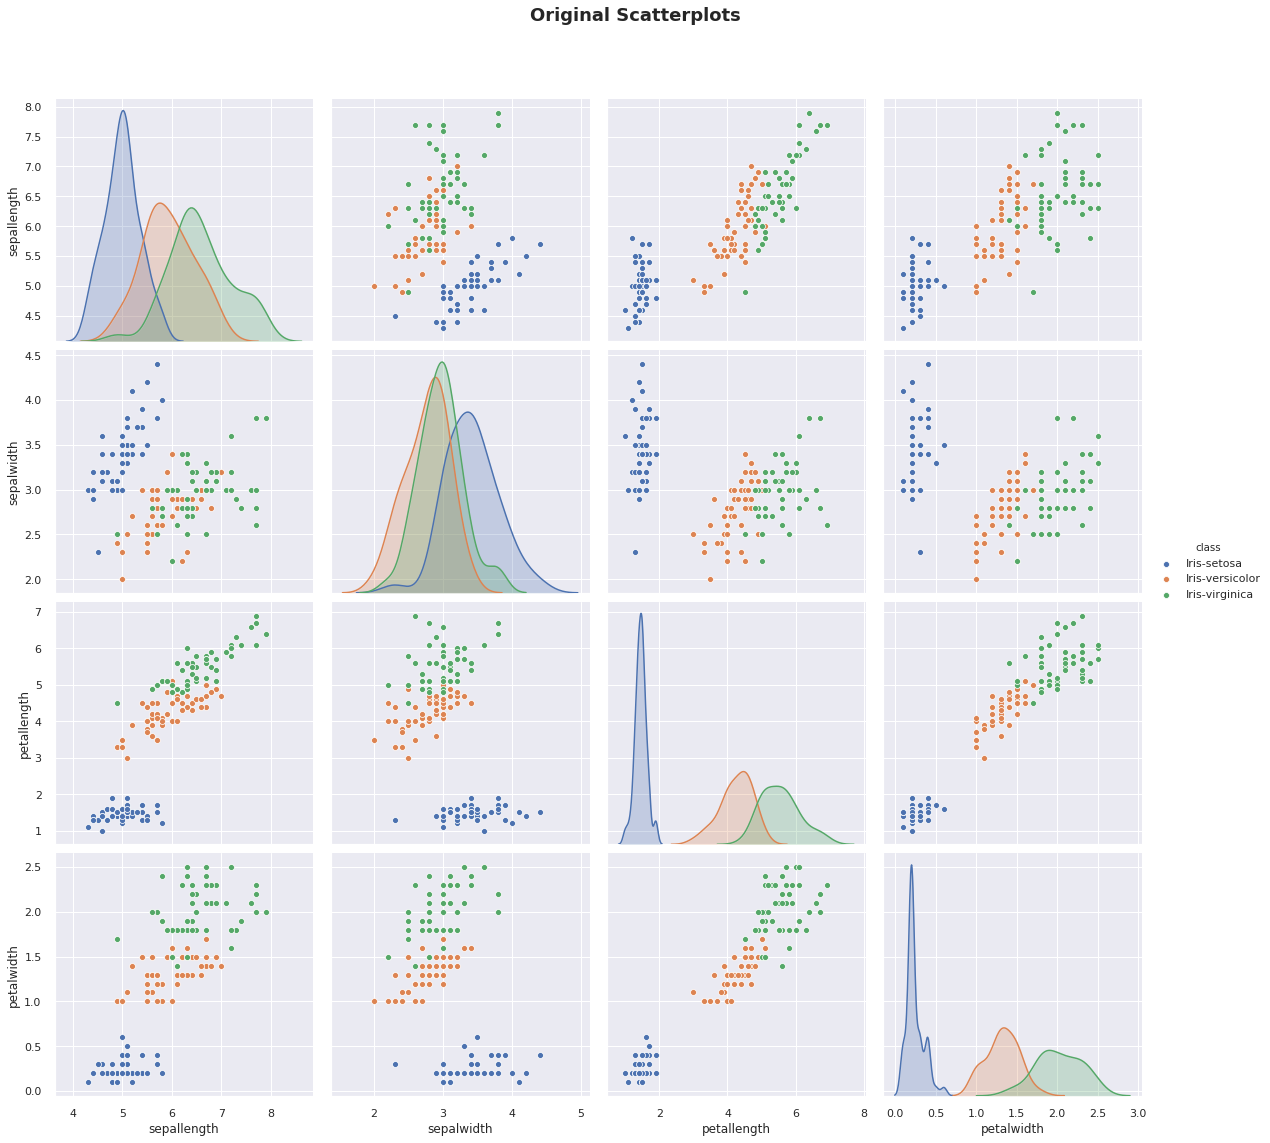

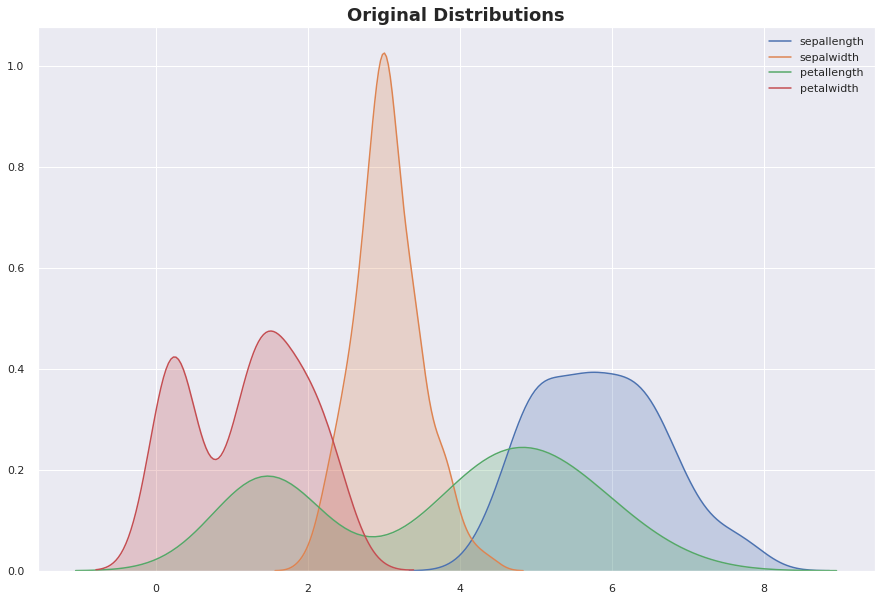

In [17]:
# Importing data
url = "https://datahub.io/machine-learning/iris/r/iris.csv"
# url = 'https://datahub.io/machine-learning/ionosphere/r/ionosphere.csv' # data = data.drop(columns='a02')
# url = 'https://datahub.io/machine-learning/diabetes/r/diabetes.csv'
# url = 'https://datahub.io/machine-learning/sonar/r/sonar.csv'
# url = 'https://datahub.io/machine-learning/blood-transfusion-service-center/r/blood-transfusion-service-center.csv'
# url = 'https://datahub.io/machine-learning/glass/r/glass.csv'
# url = 'https://datahub.io/machine-learning/breast-w/r/breast-w.csv'
# url = 'https://datahub.io/machine-learning/banknote-authentication/r/banknote-authentication.csv'
# url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/wheat-seeds.csv' # header = None
# url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv' # sep = ';'
# url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv' # sep = ';'

data = pd.read_csv(url)

print(data.head())
print("Shape\t: ", data.shape)

sns.pairplot(data=data, hue="class", height=4)
plt.subplots_adjust(top=0.9)
plt.suptitle("Original Scatterplots", fontsize=18, fontweight="bold")
plt.show()

fig, (ax1) = plt.subplots(ncols=1, figsize=(15, 10))
ax1.set_title("Original Distributions", fontsize=18, fontweight="bold")

for col in data.iloc[:, :-1].columns:
    sns.kdeplot(data[col], ax=ax1, shade=True)

plt.show()

### TAHAP 5: Merapikan (*preprocess*) data
Selanjutnya kita akan membuat data menjadi lebih rapi. Ada beberapa tahapan yang dilakukan.

1. Mengisi nilai data yang kosong. Data yang kosong dapat diisi dengan mean, median, mode, konstanta, atau bahkan di-drop satu barisnya secara langsung.
2. Memberi label numerik pada data kategorikal menggunakan fitur `get_dummies` yang dimiliki oleh Pandas sehingga data dapat diolah. (Saat ini fitur sedang di-*comment* karena fitur data bersifat numerik)
3. Melakukan *scaling* terhadap data menggunakan salah satu dari metode berikut:
    1. MinMax : Mengubah fitur dengan meng-*scaling* setiap fitur ke jarak tertentu.
    2. Standard : Mengstandarisasi fitur dengan membuang rata-ratanya (menjadi 0) dan meng-*scaling* fitur sesuai unit variance.
    3. Robust : Mengubah fitur menggunakan statistika yang kuat terhadap outlier.

Setelah itu, 5 data teratas akan dicetak dan pairplot dan kdeplot (distribusi) dari data tersebut juga akan dicetak menggunakan pyplot dan seaborn.

   sepallength  sepalwidth  petallength  petalwidth        class
0     0.222222    0.625000     0.067797    0.041667  Iris-setosa
1     0.166667    0.416667     0.067797    0.041667  Iris-setosa
2     0.111111    0.500000     0.050847    0.041667  Iris-setosa
3     0.083333    0.458333     0.084746    0.041667  Iris-setosa
4     0.194444    0.666667     0.067797    0.041667  Iris-setosa
Shape	:  (150, 5)


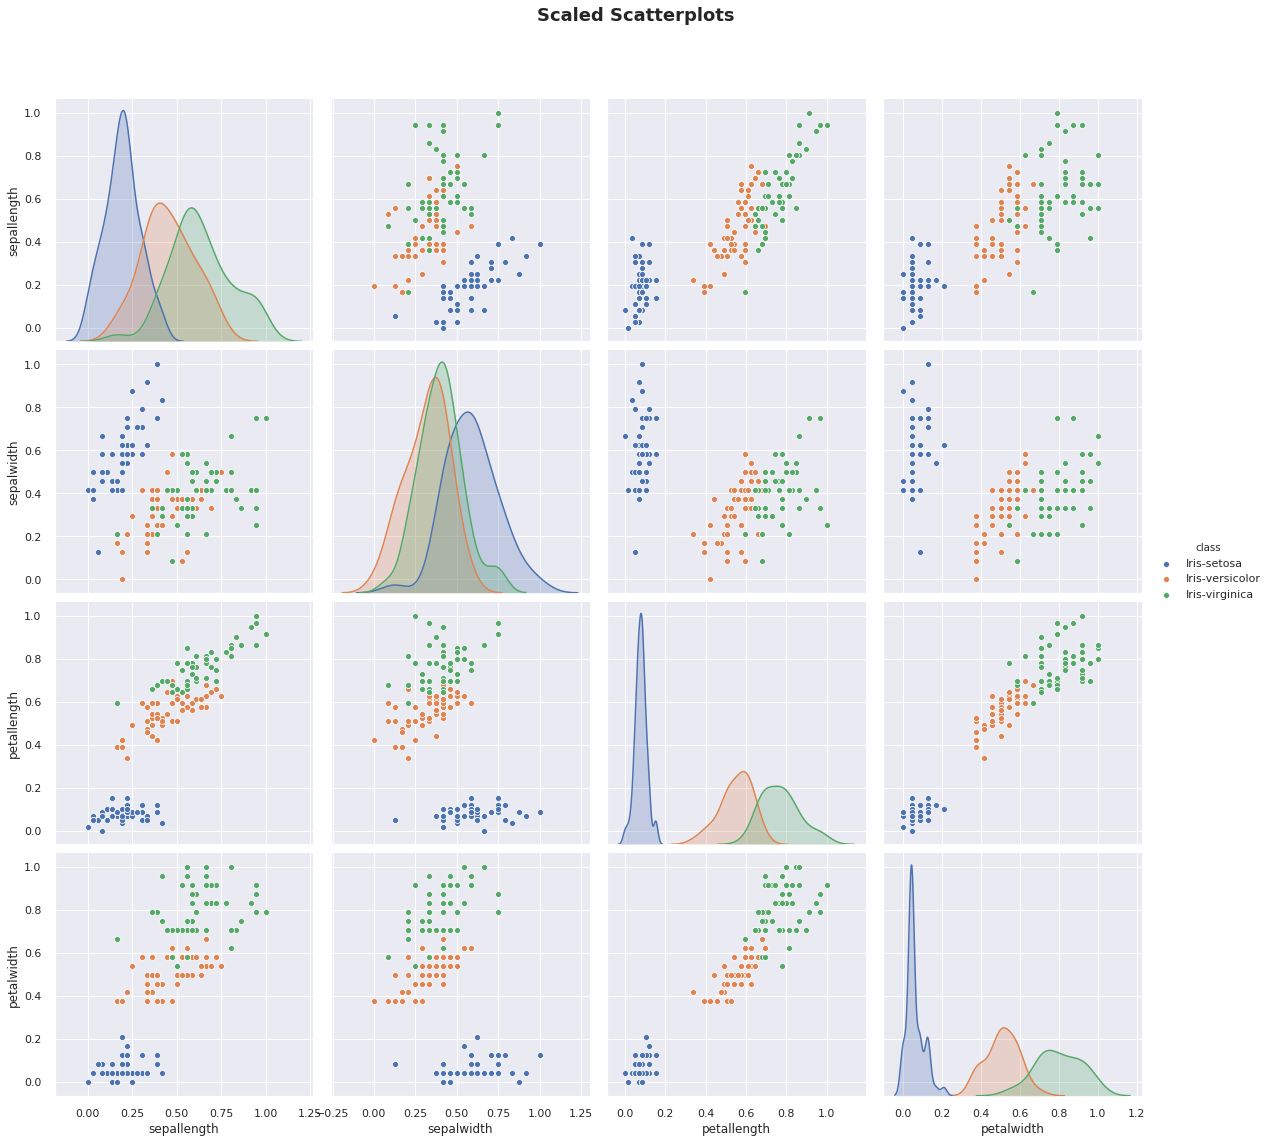

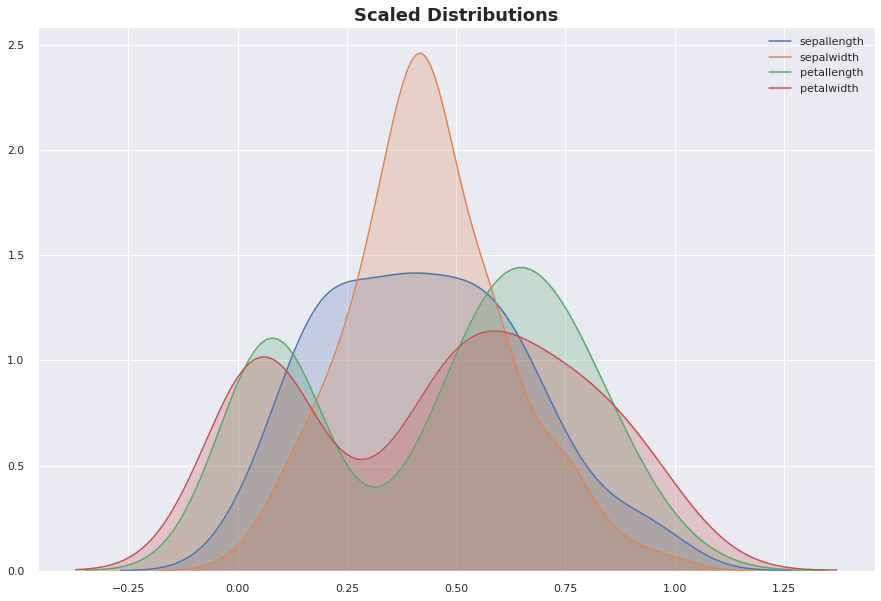

In [18]:
# Preproceessing data by removing or replacing missing value
data = Preprocessing().impute(data, missing_values=0, strategy="mean")

# Get dummies if feature are categorical, refer to https://towardsdatascience.com/encoding-categorical-features-21a2651a065c
# data.iloc[:, :-1] = pd.get_dummies(data.iloc[:, :-1], prefix_sep='_', drop_first=True)

# Scaling the features data
data.iloc[:, :-1] = Preprocessing().min_max_scale(data.iloc[:, :-1])
# data.iloc[:, :-1] = Preprocessing().standard_scale(data.iloc[:, :-1])
# data.iloc[:, :-1] = Preprocessing().robust_scale(data.iloc[:, :-1])

print(data.head())
print("Shape\t: ", data.shape)

sns.pairplot(data=data, hue="class", height=4)
plt.subplots_adjust(top=0.9)
plt.suptitle("Scaled Scatterplots", fontsize=18, fontweight="bold")
plt.show()

fig, (ax1) = plt.subplots(ncols=1, figsize=(15, 10))
ax1.set_title("Scaled Distributions", fontsize=18, fontweight="bold")

for col in data.iloc[:, :-1].columns:
    sns.kdeplot(data[col], ax=ax1, shade=True)

plt.show()

### TAHAP 6: Memprediksi dan mengevaluasi model KNN
Selanjutnya, implementasi algoritme KNN yang telah dibuat akan diuji coba menggunakan 2 metode ModelSelection yaitu:

1. `train_test_split`
2. `kfold cross validation`

Di sini juga akan dibandingkan hasil evaluasi model yang telah kita buat dengan model yang digunakan oleh library scikit.

#### 6.1 **`train_test_split`**
Model ini membagi data menjadi 2 bagian yaitu train set dan test set. Pada implementasi di bawah, data akan dibagi menjadi 80% train set dan 20% test set. 

===Using our model===
Score (k = 11)	: 0.96667


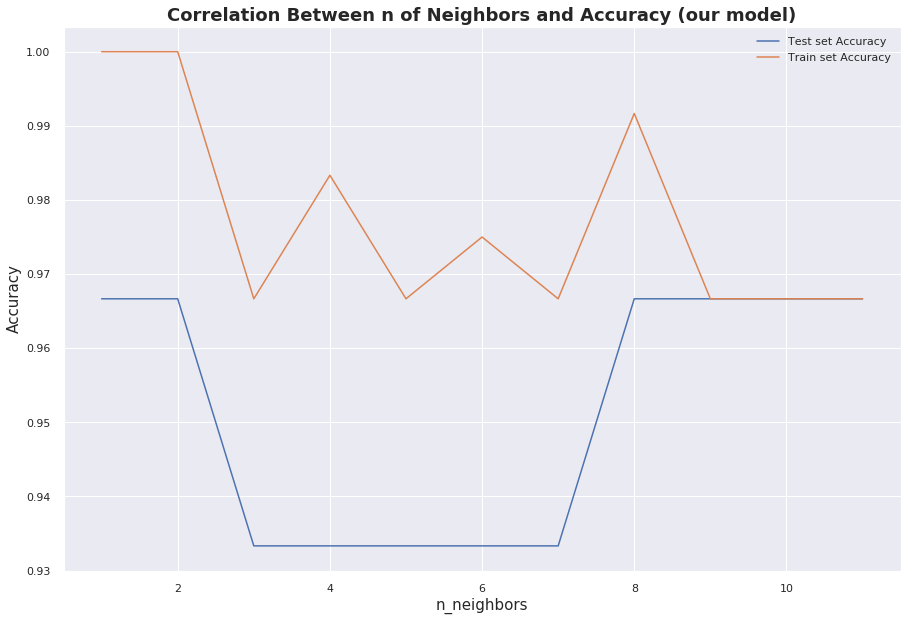

[0.96666667 0.96666667 0.93333333 0.93333333 0.93333333 0.93333333
 0.93333333 0.96666667 0.96666667 0.96666667 0.96666667]

===Using scikit===
Score (k = 11)	: 0.96667


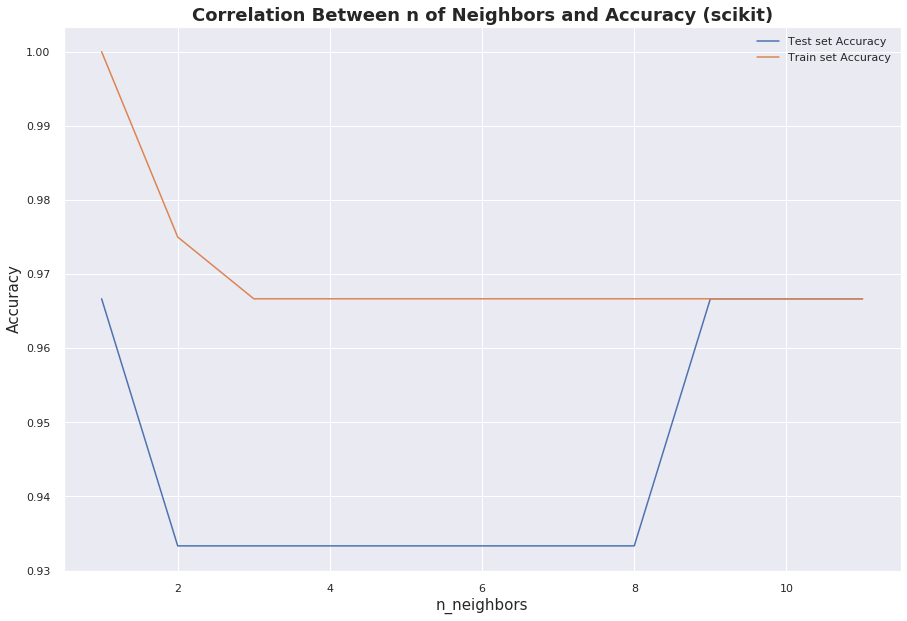

[0.96666667 0.93333333 0.93333333 0.93333333 0.93333333 0.93333333
 0.93333333 0.93333333 0.96666667 0.96666667 0.96666667]


In [21]:
# Splitting data into features (X) and target (y)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

print("===Using our model===")

# Splitting the data into 80% train and 20% test set with a random seed of 42
X_train, X_test, y_train, y_test = ModelSelection().train_test_split(
    X, y, train_size=0.8, random_state=42
)

# Fitting and printing the score of KNN
knn = KNearestNeighbors()
knn.fit(X_train, y_train)

# Getting the accuracy score for k in 0 < k < sqrt(num of rows)
# neighbors, train_accuracy, test_accuracy, best_k = knn.iterate_neighbors(
#     X_test, y_test, max_k=int(np.sqrt(X.shape[0]))
# )
neighbors, train_accuracy, test_accuracy, best_k = Tools().knn_best_k_default(
    knn, X_test, y_test, max_k=int(np.sqrt(X.shape[0]))
)

# Printing the score of KNN with best n_neighbors
knn.n_neighbors = best_k
print("Score (k = %d)\t: %.5f" % (knn.n_neighbors, knn.score(X_test, y_test)))

# Generating plot to view where is the best k for accuracy with x axis being "n_neighbors"
plt.figure(figsize=(15,10))
plt.plot(neighbors, test_accuracy, label="Test set Accuracy")
plt.plot(neighbors, train_accuracy, label="Train set Accuracy")

plt.legend(loc="best")
plt.xlabel("n_neighbors", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.title("Correlation Between n of Neighbors and Accuracy (our model)", fontsize=18, fontweight="bold")
plt.show()
print(test_accuracy)


########################################################


print("\n===Using scikit===")

from sklearn.neighbors import KNeighborsClassifier

neighbors2 = np.arange(1, int(np.sqrt(X.shape[0])))
train_accuracy2 = np.empty(len(neighbors))
test_accuracy2 = np.empty(len(neighbors))
best_k2, best_accuracy2 = 0, 0

# Loop over K values
for i, k in enumerate(neighbors2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Compute traning and test data accuracy
    train_accuracy2[i] = knn.score(X_train, y_train)
    test_accuracy2[i] = knn.score(X_test, y_test)
    if test_accuracy2[i] >= best_accuracy2:
        best_accuracy2 = test_accuracy[i]
        best_k2 = neighbors[i]

knn = KNeighborsClassifier(n_neighbors=best_k2)
knn.fit(X_train, y_train)
print("Score (k = %d)\t: %.5f" % (best_k2, knn.score(X_test, y_test)))

# Generating plot to view where is the best k for accuracy with x axis being "n_neighbors"
plt.figure(figsize=(15,10))
plt.plot(neighbors, test_accuracy2, label="Test set Accuracy")
plt.plot(neighbors, train_accuracy2, label="Train set Accuracy")

plt.legend(loc="best")
plt.xlabel("n_neighbors", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.title("Correlation Between n of Neighbors and Accuracy (scikit)", fontsize=18, fontweight="bold")
plt.show()
print(test_accuracy2)

#### 6.1 **`cross_val_score`**
Model ini membagi data menjadi sejumlah k, lalu membagi tiap k data ini menjadi k fold. Model lalu akan dilatih dengan k-1 fold data (train set) dan dites dengan 1 fold data lainnya (test set).

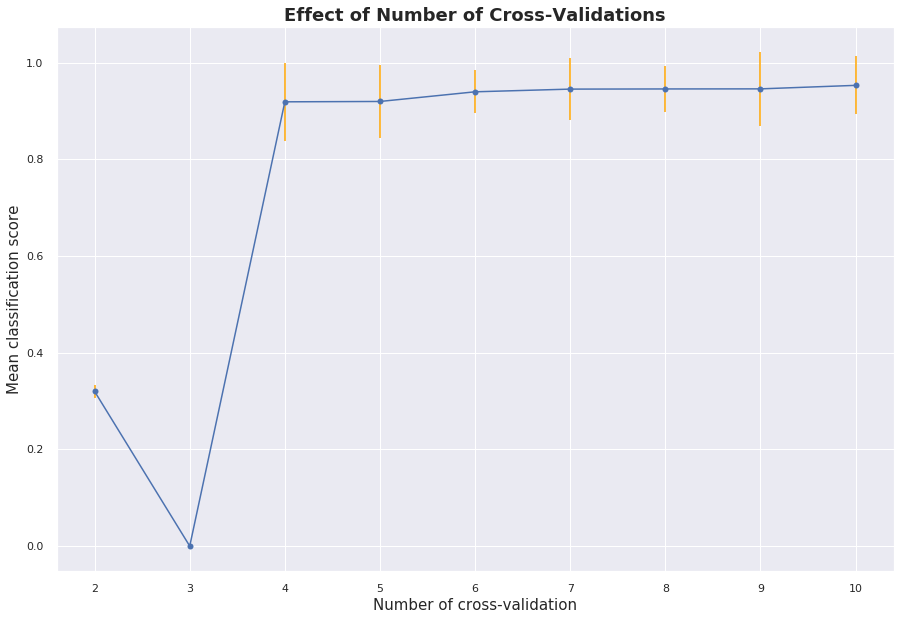

In [22]:
# The effect of number of cross-validations
knn = KNearestNeighbors()
cvs = np.arange(2, 11)
cv_scores_means = []
cv_scores_std = []
best_k_fold, best_accuracy = 0, 0
for cv in cvs:
    scores = ModelSelection().cross_val_score(knn, X, y, cv=cv, random_state=42)
    cv_scores_means.append(np.mean(scores))
    cv_scores_std.append(np.std(scores))

plt.figure(figsize=(15,10))
plt.errorbar(cvs, cv_scores_means, yerr=cv_scores_std, fmt="o-b", ecolor="orange")
plt.title("Effect of Number of Cross-Validations", fontsize=18, fontweight="bold")
plt.xlabel("Number of cross-validation", fontsize=15)
plt.ylabel("Mean classification score", fontsize=15)
plt.show()

In [23]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
print(gnb.score(X_test, y_test))

0.9333333333333333


In [24]:
best_acc3, best_k3, best_kfold3 = Tools.knn_best_k_and_kfold(
    KNearestNeighbors(), X, y, max_k=int(np.sqrt(X.shape[0]))
)
print("BEST CONFIGURATION OF KNN WITH CV")
print(
    "BEST K = {0}\nBEST KFOLD = {1}\nBEST ACC = {2}\n".format(
        best_k3, best_kfold3, best_acc3
    )
)

# Comparing models with cross validation
print("For KNN using n_neighbors = ", best_k3)
print("and k_fold = ", 10)
models = []
models.append(("KNN (ours)", KNearestNeighbors(n_neighbors=best_k3)))
models.append(("KNN (scikit)", KNeighborsClassifier(n_neighbors=best_k3)))
models.append(("GNB (scikit)", GaussianNB()))
for name, model in models:
    score = ModelSelection().cross_val_score(model, X, y, cv=10, random_state=42)
    print(
        "Model: {0}, Acuracy: {1:.5f} (+/- {2:.5f})".format(
            name, np.mean(score), np.std(score) * 2
        )
    )

BEST CONFIGURATION OF KNN WITH CV
BEST K = 11
BEST KFOLD = 2
BEST ACC = 0.9533333333333334

For KNN using n_neighbors =  11
and k_fold =  10
Model: KNN (ours), Acuracy: 0.94667 (+/- 0.13064)
Model: KNN (scikit), Acuracy: 0.94667 (+/- 0.13064)
Model: GNB (scikit), Acuracy: 0.94667 (+/- 0.11624)
